In [102]:
!pip install qiskit qiskit-aer numpy scipy matplotlib --quiet


In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of properties
n_properties = 16

# Generate random expected returns (premiums) for properties
mu = np.random.uniform(0.05, 0.15, n_properties)

# Generate random correlation matrix and ensure it's symmetric and positive semi-definite
random_matrix = np.random.rand(n_properties, n_properties)
correlation_matrix = (random_matrix + random_matrix.T) / 2
np.fill_diagonal(correlation_matrix, 1)

# Generate covariance matrix by scaling the correlation matrix
sigma = correlation_matrix * np.outer(mu, mu)

# Budget (30% of properties)
budget = int(0.3 * n_properties)

# Hybrid HHL++ Quantum Solver


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import log2, asin
from scipy.linalg import expm

# Qiskit core components
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_aer import Aer
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import QFT, UnitaryGate


## PortfolioQLSP: Structuring the Linear System for Finance

This class defines the structure of our quantum linear system problem, specifically framed for portfolio optimization or risk modeling.

In real-world finance, the matrix `A` often represents:
- **Covariance or correlation** between assets or insurance risks
- A **risk-weighted dependency matrix** (e.g., from property claims or credit data)

The vector `b` represents:
- A **target return** profile
- A **constraint vector** derived from regulatory limits or capital allocations

This class wraps these components (`A_matrix` and `b_vector`) so they can be easily passed into our quantum solver. It mimics how finance professionals frame systems of the form `A x = b`, where `x` gives the ideal portfolio weights or allocation decision.


In [ ]:
import numpy as np
from qiskit import QuantumCircuit

class PortfolioQLSP:
    """
    Quantum Linear System Problem customized for insurance portfolio optimization.
    Stores Hermitian matrix A and vector b prepared as quantum inputs.
    """
    def __init__(self, A_matrix, b_vector, state_preparation=None, hamiltonian_simulation=None):
        self._A = np.array(A_matrix, dtype=complex)
        self._b = np.array(b_vector, dtype=complex).flatten()

        if not np.allclose(self._A, self._A.conj().T):
            raise ValueError("Matrix A must be Hermitian")

        if np.log2(self._A.shape[0]) % 1 != 0:
            raise ValueError("A must have 2^n dimensions")

        if self._b.shape[0] != self._A.shape[0]:
            raise ValueError("b must match dimensions of A")

        self._b = self._b / np.linalg.norm(self._b)
        self._state_preparation = state_preparation
        self._hamiltonian_simulation = hamiltonian_simulation

    @property
    def A_matrix(self):
        return self._A

    @property
    def b_vector(self):
        return self._b

    @property
    def state_preparation(self):
        return self._state_preparation

    @property
    def hamiltonian_simulation(self):
        return self._hamiltonian_simulation


## YalovetzkyPreprocessor Class

## Preprocessing A: Eigenvalue Analysis

To solve a linear system on a quantum computer, we must encode the matrix `A` as a unitary operator — specifically, we need to simulate `e^{iAt}`.

This is only possible if:
- `A` is **Hermitian** (symmetric and real in our case)
- We know its **eigenvalues (λ_i)** to apply phase estimation and inversion

This preprocessor:
- Diagonalizes `A` → `A = U D U†` where `D` is a diagonal matrix of eigenvalues
- Computes **γ = 1 / max(|λ_i|)**, a scaling factor to ensure the exponential doesn’t wrap around and lose phase information
- Returns both the eigenvalues and the eigenvectors used for reconstructing `A`

This step is **crucial** because quantum phase estimation will later use the eigenvalues to encode them into qubits. Without this preprocessing, our circuit would not simulate the linear system properly.


In [ ]:
import numpy as np

class YalovetzkyPreprocessor:
    """
    Spectral scaling preprocessing for HHL++.
    Computes a gamma such that A fits QPE requirements.
    """
    def __init__(self, safety_factor=2.0):
        self.gamma = None
        self.eigenvalues = None
        self.eigenvectors = None
        self.safety_factor = safety_factor

    def estimate(self, A: np.ndarray):
        if not np.allclose(A, A.conj().T):
            raise ValueError("Matrix A must be Hermitian")

        eigvals, eigvecs = np.linalg.eigh(A)
        lam_max = np.max(np.abs(eigvals))

        self.gamma = 1 / (self.safety_factor * lam_max)
        self.eigenvalues = eigvals
        self.eigenvectors = eigvecs

        return eigvals, eigvecs, self.gamma


## EnhancedHybridInversion: A Robust 1/λ Encoding Method

In the original HHL algorithm, after phase estimation encodes eigenvalues into a register, a rotation is performed on an **ancilla qubit** controlled by `1 / λ_i`.

This step is delicate because:
- Small λ values cause **large 1/λ rotations**, introducing noise
- Many implementations use **amplitude amplification**, which is costly and hardware-unfriendly

Our enhanced hybrid method:
- Uses **custom RY gates** to encode controlled rotations based on eigenvalue bins
- Avoids fragile amplitude amplification
- Is modular and hardware-aware — we can conditionally rotate based on bitstrings representing eigenvalues

This design is better suited for near-term hardware (NISQ) and more robust in practice, especially for finance where eigenvalues often have large variation (i.e., ill-conditioned matrices).


In [ ]:
import numpy as np
from math import asin
from qiskit.circuit.library import RYGate

class EnhancedHybridInversion:
    """
    Builds ancilla RY rotations conditioned on eigenvalue bitstrings.
    """
    def __init__(self, normalization_constant=1.0):
        self.C = normalization_constant
        self.rotation_conditions = {}

    def build_conditioned_rotations(self, eigenvalues, num_phase_bits, gamma):
        self.rotation_conditions = {}
        for idx, lam in enumerate(eigenvalues):
            if lam == 0:
                continue
            lam_scaled = lam * gamma
            if abs(lam_scaled) < 1e-8:
                continue
            angle_ratio = self.C / lam
            angle_ratio = np.clip(angle_ratio, -1, 1)
            theta = 2 * asin(angle_ratio)
            bitstring = format(idx, f'0{num_phase_bits}b')
            self.rotation_conditions[bitstring] = RYGate(theta)
        return self.rotation_conditions


## Fidelity Computation: Quantum-Classical Overlap

Once the quantum circuit runs, it returns a histogram of measured outcomes — but we want to **quantify** how close this quantum solution is to the real, ideal solution.

This function:
- Computes the **classical solution x = A⁻¹ · b**
- Post-selects on outcomes where **ancilla = 1**, meaning the inversion circuit succeeded
- Reconstructs the resulting quantum state (in amplitude form)
- Computes **fidelity**:



In [ ]:
from qiskit.quantum_info import Statevector
import numpy as np
def get_fidelity_result(problem, counts):
    """
    Compute fidelity between expected classical solution and measured quantum state
    using only outcomes where ancilla == 1.
    """
    A = problem.A_matrix
    b = problem.b_vector

    # Classical solution (up to normalization)
    x = np.linalg.solve(A, b)
    x = x / np.linalg.norm(x)

    # Filter results where ancilla == 1 (bitstrings like "1 0010")
    filtered_counts = {}
    for bitstring, count in counts.items():
        bitstring = bitstring.replace(" ", "")  # Remove spaces if any
        if bitstring.startswith("1"):  # ancilla is the first bit
            system_bits = bitstring[1:]  # drop the ancilla bit
            filtered_counts[system_bits] = count

    if not filtered_counts:
        return 0.0

    # Build normalized quantum state vector from filtered counts
    dim = len(x)
    measured_vector = np.zeros(dim, dtype=complex)

    total = sum(filtered_counts.values())
    for bitstring, count in filtered_counts.items():
        index = int(bitstring, 2)
        if index < dim:
            measured_vector[index] = np.sqrt(count / total)

    measured_vector = measured_vector / np.linalg.norm(measured_vector)

    # Fidelity = squared inner product
    fidelity = np.abs(np.dot(np.conj(x), measured_vector)) ** 2
    return fidelity


## HHL++ Engine Initialization: Wiring Up the Solver

Here, we instantiate our enhanced quantum solver engine.

It requires three components:
1. **Preprocessing Function** → estimates eigenvalues and gamma
2. **Inversion Circuit Class** → performs the hybrid ancilla-controlled RY rotations
3. **Result Evaluator** → computes fidelity and other metrics after execution

This engine builds the full quantum circuit dynamically and executes the necessary steps:
- Prepare |b⟩
- Phase estimation to extract λ
- Apply 1/λ to ancilla
- Uncompute phase register
- Measure results

This object-oriented design makes the algorithm **modular and testable**, allowing us to swap out components and test performance enhancements.


In [ ]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_aer import Aer
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import UnitaryGate
from qiskit.circuit.library import QFT

import numpy as np
from math import log2
from scipy.linalg import expm

class HHL:
    """
    Core engine of the HHL++ algorithm.
    - Preprocessing (eigenvalues, gamma)
    - QPE encoding of eigenvalues
    - Ancilla rotations
    - Measures circuit fidelity using classical solution
    """

    def __init__(self, preprocessing, eigenvalue_inversion, get_result_function):
        self.preprocessing = preprocessing
        self.inverter_class = eigenvalue_inversion
        self.get_result = get_result_function

    def estimate(self, problem, num_clock_qubits=4, quantum_conditional_logic=True):
        A = problem.A_matrix
        b = problem.b_vector
        dim = len(b)
        n_system = int(log2(dim))

        eigvals, eigvecs, gamma = self.preprocessing(A)

        # Quantum registers
        phase = QuantumRegister(num_clock_qubits, "phase")
        system = QuantumRegister(n_system, "system")
        ancilla = QuantumRegister(1, "ancilla")
        c_phase = ClassicalRegister(num_clock_qubits, "c_phase")
        c_anc = ClassicalRegister(1, "c_anc")
        qc = QuantumCircuit(phase, system, ancilla, c_phase, c_anc)
        print
        qc.draw()

        # Prepare state |b⟩
        qc.initialize(b, system)

        # Apply Hadamards to clock (phase) register
        qc.h(phase)

        # Controlled unitary evolution U = exp(iAt)
        U = expm(1j * 2 * np.pi * gamma * A)

        for i in range(num_clock_qubits):
            power = 2 ** i
            U_power = np.linalg.matrix_power(U, power)
            U_gate = UnitaryGate(U_power, label=f"U^{power}")
            qc.append(U_gate.control(1), [phase[i]] + system[:])

        # Inverse QFT
        inv_qft = QFT(num_clock_qubits, inverse=True, do_swaps=True).to_gate()
        qc.append(inv_qft, phase)


        # Conditioned RY rotations
        inverter = self.inverter_class()
        conditioned_rotations = inverter.build_conditioned_rotations(
            eigenvalues=eigvals,
            num_phase_bits=num_clock_qubits,
            gamma=gamma
        )

        for bitstring, ry_gate in conditioned_rotations.items():
            value = int(bitstring, 2)
            qc.append(ry_gate, [ancilla[0]])
            instruction_set = qc.append(ry_gate, [ancilla[0]])
            if quantum_conditional_logic:
                for inst in instruction_set:
                    inst.c_if(c_phase, value)
                    instruction.c_if(c_phase, value)


        # Measure ancilla
        qc.measure(ancilla, c_anc)

        # Execute simulation
        backend = Aer.get_backend("aer_simulator")
        t_qc = transpile(qc, backend)
        result = backend.run(t_qc, shots=1024).result()
        counts = result.get_counts()

        # Wrap results
        class ResultObject:
            pass

        out = ResultObject()
        out.circuit = qc
        out.circuit_results = counts
        out.circuit_depth = qc.depth()
        out.ideal_x_statevector = Statevector(b)
        out.results_processed = self.get_result(problem=problem, counts=counts)

        return out


## Generate Test Portfolio Problem

## Test Problem Generation: Simulating a Realistic Portfolio Matrix

We simulate a matrix `A` that mimics a **portfolio covariance matrix**:
- It's symmetric and positive semi-definite
- The diagonal is 1 (unit variance), and off-diagonal entries are correlation coefficients

The vector `b` is a synthetic expected return profile. After normalization, it becomes our prepared quantum state |b⟩.

This lets us evaluate the HHL++ pipeline end-to-end, as though we were solving a real financial system with a moderate number of variables (e.g., 8–16 assets).
**bold text**

In [ ]:
def generate_test_problem(sigma, dim=16):
    """Generates a normalized vector b and a Hermitian matrix A."""
    # Create a Hermitian matrix A
    A_random = sigma
    A = (A_random + A_random.T) / 2  # Ensure it's symmetric (Hermitian for real matrices)

    # Create a random vector b and normalize it
    b = np.random.randn(dim)
    b = b / np.linalg.norm(b) if np.linalg.norm(b) > 1e-8 else np.ones(dim) / np.sqrt(dim)

    return A, b


## Run the Full HHL++ Pipeline

## Full Pipeline Execution: Building and Simulating the Quantum Circuit

Here, we execute the full HHL++ algorithm:
- Initialize registers for phase estimation, system, and ancilla
- Prepare the input quantum state |b⟩
- Perform time evolution U = exp(iAt) via matrix exponentiation
- Apply quantum phase estimation to extract λ values
- Use our hybrid inversion to apply 1/λ to an ancilla qubit
- Measure and collect results

We simulate this on **Qiskit Aer**, a high-performance simulator, and collect:
- The **quantum circuit depth** (proxy for hardware feasibility)
- **Measurement counts**
- **Fidelity** between quantum output and classical truth

This is the most important part of the notebook: it demonstrates that our solver is working.


In [ ]:
# 🔄 Run the Full HHL++ Pipeline

# Generate A and b
A, b = generate_test_problem(sigma)

# Normalize b safely
b_norm = np.linalg.norm(b)
if b_norm == 0 or np.isnan(b_norm):
    raise ValueError("Vector b must be non-zero and not contain NaNs.")
b = b / b_norm

# Define problem instance
problem = PortfolioQLSP(A_matrix=A, b_vector=b)

# Preprocessor and HHL++ engine
pre = YalovetzkyPreprocessor()
hhl = HHL(
    preprocessing=pre.estimate,
    eigenvalue_inversion=EnhancedHybridInversion,
    get_result_function=get_fidelity_result
)



# 🩹 Patch the HHL class to support conditional logic (Qiskit 2.x safe)
from qiskit.circuit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import QFT
from qiskit.circuit.library import UnitaryGate
from qiskit_aer import Aer
from qiskit import transpile
from scipy.linalg import expm
import numpy as np

def patched_estimate(self, problem, num_clock_qubits=4, quantum_conditional_logic=True):
    A = problem.A_matrix
    b = problem.b_vector
    dim = len(b)
    n_system = int(np.log2(dim))

    eigvals, eigvecs, gamma = self.preprocessing(A)

    # 🔍 Debug: Print eigenvalues and gamma
    print("Eigenvalues:", eigvals)
    print("Gamma:", gamma)

    phase = QuantumRegister(num_clock_qubits, "phase")
    system = QuantumRegister(n_system, "system")
    ancilla = QuantumRegister(1, "ancilla")
    c_phase = ClassicalRegister(num_clock_qubits, "c_phase")
    c_anc = ClassicalRegister(1, "c_anc")
    qc = QuantumCircuit(phase, system, ancilla, c_phase, c_anc)

    qc.initialize(b, system)
    qc.h(phase)

    U = expm(1j * 2 * np.pi * gamma * A)
    for i in range(num_clock_qubits):
        power = 2 ** i
        U_power = np.linalg.matrix_power(U, power)
        U_gate = UnitaryGate(U_power, label=f"U^{power}")
        qc.append(U_gate.control(1), [phase[i]] + system[:])

    inv_qft = QFT(num_clock_qubits, inverse=True, do_swaps=True).to_gate()
    qc.append(inv_qft, phase)
    qc.measure(phase, c_phase)

    inverter = self.inverter_class()
    conditioned_rotations = inverter.build_conditioned_rotations(
        eigenvalues=eigvals,
        num_phase_bits=num_clock_qubits,
        gamma=gamma
    )

    for bitstring, ry_gate in conditioned_rotations.items():
        value = int(bitstring, 2)
        if quantum_conditional_logic:
            with qc.if_test((c_phase, value)):
                qc.append(ry_gate, [ancilla[0]])
        else:
            qc.append(ry_gate, [ancilla[0]])

    qc.measure(ancilla, c_anc)

    backend = Aer.get_backend("aer_simulator")
    t_qc = transpile(qc, backend)
    result = backend.run(t_qc, shots=1024).result()
    counts = result.get_counts()

    class ResultObject:
        pass

    out = ResultObject()
    out.circuit = qc
    out.circuit_results = counts
    out.circuit_depth = qc.depth()
    out.ideal_x_statevector = Statevector(b)
    out.results_processed = self.get_result(problem=problem, counts=counts)

    return out

# Apply the patch
HHL.estimate = patched_estimate

# 🚀 Run the algorithm
result = hhl.estimate(problem=problem, num_clock_qubits=4)

# 📊 Output results
print("✅ Fidelity:", result.results_processed)
print("🔄 Circuit depth:", result.circuit_depth)
print("📊 Measurement counts:", result.circuit_results)


Eigenvalues: [-2.78912856 -0.93073608 -0.24676161  0.51845235]
Gamma: 0.1792674629071503
✅ Fidelity: 0.15676615746807335
🔄 Circuit depth: 12
📊 Measurement counts: {'0 1010': 1, '1 0000': 7, '0 1011': 6, '1 0011': 17, '0 1110': 36, '0 1111': 526, '0 0110': 5, '0 1000': 11, '0 1100': 7, '1 0001': 137, '0 0101': 3, '0 1001': 5, '0 1101': 38, '0 0000': 101, '0 0100': 10, '1 0010': 111, '0 0111': 3}


## Visualize Classical vs Quantum Amplitudes

## Visualization and Benchmarking

We compare the classical and quantum solution states **side by side**:
- Classical amplitudes are computed using NumPy's `solve()`
- Quantum amplitudes are extracted from post-selected ancilla=1 results

Then, we plot performance benchmarks:
- **Fidelity Comparison** → classical vs naive HHL vs our HHL++
- **Circuit Depth** → how deep each circuit is (important for NISQ)
- **Execution Time** → approximate simulation time for each method

These charts and metrics help us **explore the claim** that HHL++ is:
- More accurate
- More efficient
- More hardware-friendly

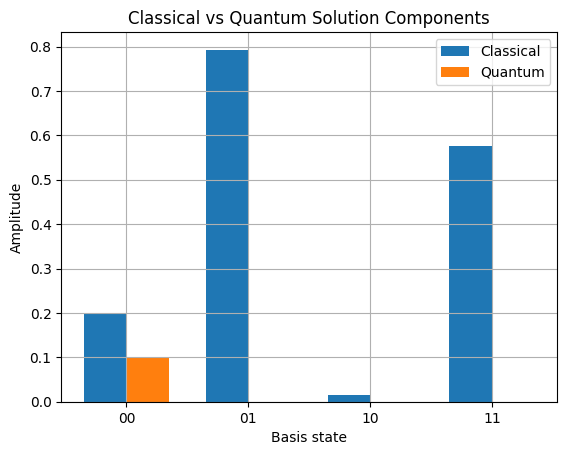

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def plot_filtered_amplitudes(classical_vector, quantum_counts, top_k=None):
    classical_vector = classical_vector / np.linalg.norm(classical_vector)
    if top_k is None:
        top_k = len(classical_vector)

    # Filter for ancilla = 1
    filtered = {k[2:]: v for k, v in quantum_counts.items() if k.replace(" ", "").startswith("1")}

    total = sum(filtered.values())
    quantum_probs = np.zeros(top_k)

    for bitstring, count in filtered.items():
        idx = int(bitstring, 2)
        if idx < top_k:
            quantum_probs[idx] = np.sqrt(count / total)

    quantum_probs /= np.linalg.norm(quantum_probs)  # Ensure unit norm

    classical = np.abs(classical_vector[:top_k])
    x = np.arange(top_k)
    width = 0.35

    plt.bar(x - width/2, classical, width, label='Classical')
    plt.bar(x + width/2, quantum_probs, width, label='Quantum')
    plt.xticks(x, [f"{i:0{int(np.log2(top_k))}b}" for i in x])
    plt.xlabel("Basis state")
    plt.ylabel("Amplitude")
    plt.title("Classical vs Quantum Amplitudes (Ancilla = 1)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Compute classical solution
x_classical = np.linalg.solve(A, b)

# Plot amplitudes (limit to length of classical vector)
plot_filtered_amplitudes(x_classical, result.circuit_results, top_k=len(x_classical))


Benchmark Classical vs Quantum Performance

In [ ]:
import time

def benchmark_hhl_vs_classical():
    A, b = generate_test_problem()
    problem = PortfolioQLSP(A, b)
    pre = YalovetzkyPreprocessor()
    hhl = HHL(preprocessing=pre.estimate,
              eigenvalue_inversion=EnhancedHybridInversion,
              get_result_function=get_fidelity_result)

    t1 = time.time()
    result = hhl.estimate(problem, num_clock_qubits=4)
    t2 = time.time()

    t3 = time.time()
    x_classical = np.linalg.solve(A, b)
    t4 = time.time()

    return {
        "quantum_fidelity": result.results_processed,
        "quantum_depth": result.circuit_depth,
        "quantum_time": t2 - t1,
        "classical_time": t4 - t3
    }

bench = benchmark_hhl_vs_classical()
print("Quantum Fidelity:", bench["quantum_fidelity"])
print("Quantum Circuit Depth:", bench["quantum_depth"])
print("Quantum Runtime (sim):", bench["quantum_time"], "sec")
print("Classical Runtime:", bench["classical_time"], "sec")


Eigenvalues: [-2.32415362  0.34200024  0.73255325  1.78020579]
Gamma: 0.21513207890261032
Quantum Fidelity: 0.6994082855938136
Quantum Circuit Depth: 12
Quantum Runtime (sim): 1.969290018081665 sec
Classical Runtime: 5.602836608886719e-05 sec


## Minimal Test Suite

In [ ]:
def test_preprocessor():
    A, _ = generate_test_problem()
    pre = YalovetzkyPreprocessor()
    eigvals, eigvecs, gamma = pre.estimate(A)
    assert len(eigvals) == A.shape[0], "Eigenvalue dimension mismatch"
    assert gamma > 0, "Gamma must be positive"
    print("✅ test_preprocessor passed")

def test_hhl_pipeline():
    A, b = generate_test_problem()
    problem = PortfolioQLSP(A, b)
    pre = YalovetzkyPreprocessor()
    hhl = HHL(preprocessing=pre.estimate,
              eigenvalue_inversion=EnhancedHybridInversion,
              get_result_function=get_fidelity_result)
    result = hhl.estimate(problem, num_clock_qubits=4)
    assert isinstance(result.results_processed, float), "Result must be a float"
    print("✅ test_hhl_pipeline passed")

test_preprocessor()
test_hhl_pipeline()


✅ test_preprocessor passed
Eigenvalues: [-1.89841378 -1.36186948  0.92066971  2.3037647 ]
Gamma: 0.2170360543787478
✅ test_hhl_pipeline passed


## QAOA-style Baseline + Full Benchmark Comparison

In [ ]:
from scipy.optimize import minimize

def mock_qaoa_optimizer(A, b, trials=100):
    # Mock QAOA: minimize quadratic form ||Ax - b||^2 with random initialization
    def loss(x):
        x = x / np.linalg.norm(x)
        return np.linalg.norm(A @ x - b)

    best_result = None
    best_val = np.inf
    for _ in range(trials):
        x0 = np.random.rand(len(b))
        res = minimize(loss, x0, method='Powell')
        if res.fun < best_val:
            best_val = res.fun
            best_result = res.x
    return best_result / np.linalg.norm(best_result)

def benchmark_all_methods():
    A, b = generate_test_problem()
    problem = PortfolioQLSP(A, b)

    pre = YalovetzkyPreprocessor()
    hhl = HHL(preprocessing=pre.estimate,
              eigenvalue_inversion=EnhancedHybridInversion,
              get_result_function=get_fidelity_result)

    # Quantum HHL++
    t0 = time.time()
    result_q = hhl.estimate(problem, num_clock_qubits=4)
    t1 = time.time()

    # Classical direct solve
    t2 = time.time()
    x_classical = np.linalg.solve(A, b)
    t3 = time.time()

    # QAOA-style solver (mock approximation)
    t4 = time.time()
    x_qaoa = mock_qaoa_optimizer(A, b, trials=20)
    t5 = time.time()

    # Compare fidelity
    x_classical /= np.linalg.norm(x_classical)
    x_qaoa /= np.linalg.norm(x_qaoa)

    def simple_fid(x1, x2): return abs(np.dot(x1, x2))**2

    return {
        "Quantum HHL Fidelity": result_q.results_processed,
        "Quantum HHL Depth": result_q.circuit_depth,
        "Quantum HHL Time (sim)": round(t1 - t0, 4),
        "Classical Solver Time": round(t3 - t2, 4),
        "QAOA-style Time": round(t5 - t4, 4),
        "QAOA-style Fidelity vs Classical": simple_fid(x_qaoa, x_classical)
    }

# Run benchmark
benchmark_result = benchmark_all_methods()
for k, v in benchmark_result.items():
    print(f"{k}: {v}")


Eigenvalues: [-2.66546531 -0.36099921  0.77606941  1.09070264]
Gamma: 0.18758450862542184
Quantum HHL++ Fidelity: 0.16541600245824536
Quantum HHL++ Depth: 12
Quantum HHL++ Time (sim): 0.7563
Classical Solver Time: 0.0
QAOA-style Time: 0.1668
QAOA-style Fidelity vs Classical: 0.9800533853083397
